In [1]:
import dlib
import cv2
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np
from mlxtend.image import extract_face_landmarks
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
from sklearn import preprocessing

In [2]:
import os

os.chdir('../root/mlxtend_data')
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [3]:
os.chdir('../../jupyter-data')

In [4]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[15], mouth[21])
    C = distance.euclidean(mouth[12], mouth[18])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

In [6]:
#Read in the Data file to Train Model
import pandas as pd
df = pd.read_csv('./data/totalwithmaininfo-re-remove27-35.csv',sep=',')
df = df.drop(['respondent','Time'],axis=1)

train_percentage = 19/23
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

df_train = df[:train_index]
df_test = df[-test_index:]

X_test = df_test.drop(["Y"],axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y',axis=1)
y_train = df_train['Y']

In [7]:
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(clf)
y_pred_1 = clf.predict(X_test)
y_pred_1 = average(y_pred_1)
# y_score_1 = clf.predict_proba(X_test)[:,1]
acc1 = accuracy_score(y_test, y_pred_1)

LogisticRegression(max_iter=1000)


In [8]:
print(acc1)

0.8902777777777777


In [9]:
def model(landmarks):

    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])

    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)

    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    if math.isnan(std["EAR"]) == False:
        df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
        df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
        df["Circularity_N"] = (df["Circularity"]-mean["Circularity"])/ std["Circularity"]
        df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]
#     else:
#         df["EAR_N"] = 0
#         df["MAR_N"] = 0
#         df["Circularity_N"] = 0
#         df["MOE_N"] = 0
    print(df.head())
    Result = clf.predict(df)
    if Result == 1:
        Result_String = "Drowsy"
    else:
        Result_String = "Alert"
    

    return Result_String, df.values

In [10]:
from imutils import face_utils
def calibration(pathArr):
    data = []
    for path in pathArr:
        img = cv2.imread(path)

        # Converting the image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(img, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)

            # Show the image
            fig = plt.figure(figsize=(15, 5))
            ax = fig.add_subplot(1, 3, 1)
            ax.imshow(img)
            plt.text(15, 15, "cab...", bbox=dict(fill=False, edgecolor='red', linewidth=2))

    cv2.destroyAllWindows()  
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","Circularity","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)
    
    return df_means,df_std

In [11]:
def live(pathArr):
    data = []
    result = []
    for path in pathArr:
        img = cv2.imread(path)
        # Converting the image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(img, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape)
            data.append (features)
            result.append(Result_String)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(img)
        plt.text(15, 15, Result_String, bbox=dict(fill=False, edgecolor='red', linewidth=2))

    cv2.destroyAllWindows()
    
    return data,result

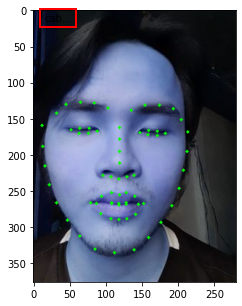

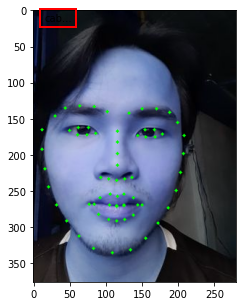

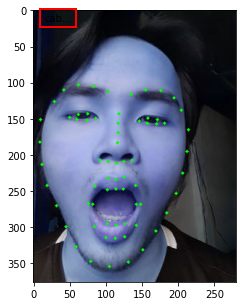

In [12]:
#Run Calibration
mean, std = calibration(['./data/eye_close_1.jpg','./data/eye_open.jpg','./data/mouth_open.jpg'])

In [13]:
print(mean.head())
print(std.head())

EAR            0.234137
MAR            0.685600
Circularity    0.371256
MOE            3.000989
dtype: float64
EAR            0.042175
MAR            0.380512
Circularity    0.030466
MOE            1.733457
dtype: float64


        EAR       MAR  Circularity       MOE    EAR_N    MAR_N  Circularity_N  \
0  0.279501  0.465911     0.404583  1.666939  1.07562 -0.57735       1.093924   

     MOE_N  
0 -0.76959  


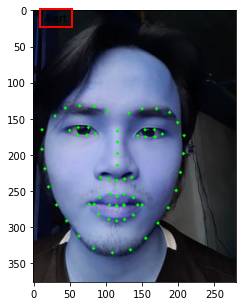

In [18]:
features, result = live(['./data/eye_open.jpg'])

In [20]:
os.getcwd()

'/jupyter-data'